This is the script that will help me identify the most confusable and discriminable digits according to our ensemble model.

In [1]:
import json
import base64
import io
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
from scipy import stats
import torch
from torchvision import transforms
from PIL import Image

# Import your models
from mnist_skeptic_v9 import skeptic_v9  # Ensure this path is correct

# Additional imports for model ensemble
import os
import string

import torchvision.transforms as transforms
import ipywidgets as widgets
from IPython.display import display

In [2]:
# Define the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define the ModelEnsemble class
class ModelEnsemble:
    def __init__(self, models):
        self.models = models

    def __call__(self, inputs):
        outputs = [model(inputs) for model in self.models]
        return sum(outputs) / len(outputs)  # Average outputs of all models

    def eval(self):
        for model in self.models:
            model.eval()

In [3]:
def load_ensemble_models(model_class, folder_path, num_models=20, device='cpu', verbose=True):
    models = []
    
    for idx, letter in enumerate(string.ascii_lowercase[:num_models]):
        model = model_class()
        checkpoint_path = os.path.join(folder_path, f'skeptic_v10_{letter}_finetuned.pth')
        
        try:
            if not os.path.exists(checkpoint_path):
                raise FileNotFoundError(f"Model checkpoint not found: {checkpoint_path}")
            
            state_dict = torch.load(checkpoint_path, map_location=device)
            model.load_state_dict(state_dict)
            model.to(device)
            model.eval()
            models.append(model)
            
            if verbose:
                print(f"Loaded model {idx+1}/{num_models}: {checkpoint_path}")
        except Exception as e:
            print(f"Error loading model {idx+1}/{num_models}: {str(e)}")
    
    if not models:
        raise ValueError("No models were successfully loaded.")
    
    ensemble = ModelEnsemble(models)
    ensemble.eval()
    return ensemble

In [4]:
try:
    ensemble = load_ensemble_models(skeptic_v9, 'saved_models/skeptic_v10', num_models=20, device=device)
    print("Ensemble loaded successfully.")
except Exception as e:
    print(f"Error loading ensemble: {str(e)}")

C:\Users\Sai\AppData\Local\Temp\ipykernel_43320\3871472093.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_path, map_location=device)

Loaded model 1/20: saved_models/skeptic_v10\skeptic_v10_a_finetuned.pth
Loaded model 2/20: saved_models/skeptic_v10\skeptic_v10_b_finetuned.pth
Loaded model 3/20: saved_models/skeptic_v10\skeptic_v10_c_finetuned.pth
Loaded model 4/20: saved_models/skeptic_v10\skeptic_v10_d_finetuned.pth
Loaded model 5/20: saved_models/skeptic_v10\skeptic_v10_e_finetuned.pth
Loaded model 6/20: saved_models/skeptic_v10\skeptic_v10_f_finetuned.pth
Loaded model 7/20: saved_models/skeptic_v10\skeptic_v10_g_finetuned.pth
Loaded model 8/20: saved_models/skeptic_v10\skeptic_v10_h_finetuned.pth
Loaded model 9/20: saved_models/skeptic_v10\skeptic_v10_i_finetuned.pth
Loaded model 10/20: saved_models/skeptic_v10\skeptic_v10_j_finetuned.pth
Loaded model 11/20: saved_models/skeptic_v10\skeptic_v10_k_finetuned.pth
Loaded model 12/20: saved_models/skeptic_v10\skeptic_v10_l_finetuned.pth
Loaded model 13/20: saved_models/skeptic_v10\skeptic_v10_m_finetuned.pth
Loaded model 14/20: saved_models/skeptic_v10\skeptic_v10_n_f

In [5]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Define transformations for your data (adjust as needed)
transform = transforms.Compose([
    transforms.ToTensor(),
    # Add any other transformations needed
])

# Load validation dataset (assuming MNIST or similar)
validation_dataset = datasets.MNIST(root='data', train=False, transform=transform, download=True)

# Create DataLoader
validation_loader = DataLoader(validation_dataset, batch_size=64, shuffle=False)

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix
import numpy as np

# Define the ModelEnsemble class if not already defined
class ModelEnsemble:
    def __init__(self, models):
        self.models = models

    def __call__(self, inputs):
        outputs = [model(inputs) for model in self.models]
        return sum(outputs) / len(outputs)  # Average outputs of all models

    def eval(self):
        for model in self.models:
            model.eval()

# Define transformations for your data
# Data loading and preprocessing - more agrressive data augmentation
transform = transforms.Compose([
    transforms.Resize((16, 16)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load validation dataset (assuming MNIST or similar)
validation_dataset = datasets.MNIST(root='data', train=False, transform=transform, download=True)

# Create DataLoader
validation_loader = DataLoader(validation_dataset, batch_size=64, shuffle=False)

# Evaluate model function
def evaluate_model(ensemble, validation_loader):
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in validation_loader:
            images = images.to(device)
            outputs = ensemble(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

# Compute confusion matrix function
def compute_confusion_matrix(preds, labels):
    return confusion_matrix(labels, preds)

# Assuming ensemble is already loaded as per previous instructions
preds, labels = evaluate_model(ensemble, validation_loader)
conf_matrix = compute_confusion_matrix(preds, labels)

print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[  2   0 600   0  77  23  18  84   8 168]
 [273   0   5   0   0   1 266   0 228 362]
 [ 79   0 207   0  39  36 175 107 195 194]
 [373   0 196   0   1 108 103  23  73 133]
 [ 32   0 620   0   6  86  73  34 127   4]
 [ 76   0 336   0   9  70 159   8  92 142]
 [ 33   0 516   0  35  76 120  32  56  90]
 [ 33   0 837   0   3   5  22   1  70  57]
 [169   0 239   2   3  42 360  21 120  18]
 [139   0 687   0   1  54  68   3  46  11]]


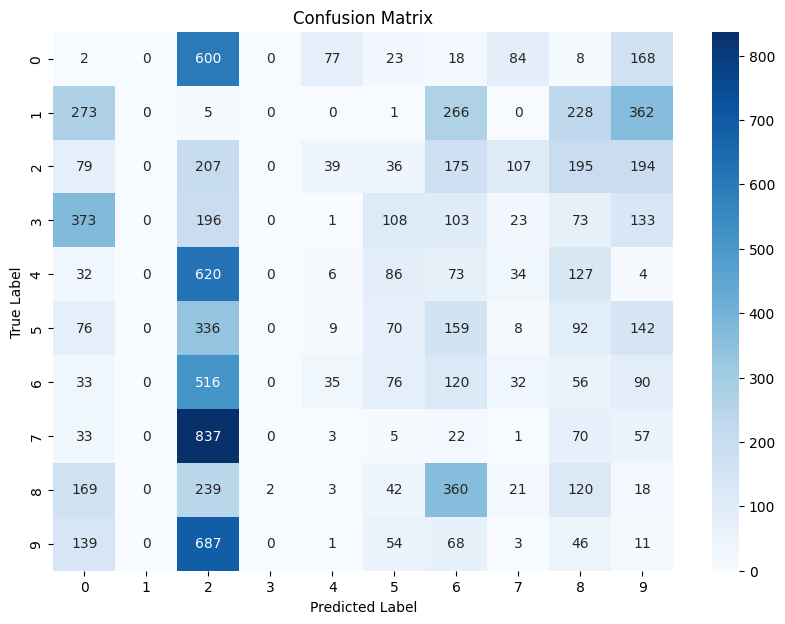

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming preds and labels are your predicted and true labels
# Compute confusion matrix
conf_matrix = confusion_matrix(labels, preds)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [9]:
# Find the most confusable digit pair
most_confusion_index = np.unravel_index(np.argmax(conf_matrix - np.eye(conf_matrix.shape[0]) * np.max(conf_matrix)), conf_matrix.shape)
most_confusable_pair = (most_confusion_index[0], most_confusion_index[1])
reason_confusable = f"Most confusable pair is: {most_confusable_pair} with {conf_matrix[most_confusion_index]} instances. This indicates that digit {most_confusable_pair[0]} is often misclassified as digit {most_confusable_pair[1]}."
print(reason_confusable)

Most confusable pair is: (7, 2) with 837 instances. This indicates that digit 7 is often misclassified as digit 2.


In [10]:
# Find the most discriminable digit
distinguishable_ratios = []
for i in range(10):
    diagonal_value = conf_matrix[i][i]
    misclassifications = np.sum(conf_matrix[i]) - diagonal_value
    ratio = diagonal_value / (misclassifications + 1e-7)  # Add small value to avoid division by zero
    distinguishable_ratios.append((i, ratio))

most_discriminable_digit = max(distinguishable_ratios, key=lambda x: x[1])
reason_discriminable = f"Most discriminable digit is: {most_discriminable_digit[0]}, with a ratio of {most_discriminable_digit[1]:.2f}. This means it has a high number of true positives compared to misclassifications."
print(reason_discriminable)

Most discriminable digit is: 2, with a ratio of 0.25. This means it has a high number of true positives compared to misclassifications.


In [11]:
import os
import zipfile
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define the transformation for images
transform = transforms.Compose([
    transforms.Resize((16, 16)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

def load_all_experimental_data(test_digits_folder):
    train_images = []
    train_labels = []
    test_images = []
    test_labels = []
    participant_data = {}

    for filename in os.listdir(test_digits_folder):
        if filename.endswith('.zip') and filename.startswith('experiment_results_participant'):
            participant_number = int(filename.split('participant')[1].split('.')[0])
            zip_filepath = os.path.join(test_digits_folder, filename)

            participant_train_images = []
            participant_train_labels = []
            participant_test_images = []
            participant_test_labels = []

            with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
                for img_filename in zip_ref.namelist():
                    if img_filename.endswith('.png'):
                        with zip_ref.open(img_filename) as file:
                            img = Image.open(file).convert('L')  # Convert to grayscale
                            img_tensor = transform(img)
                            
                            digit = int(img_filename.split('_')[0])
                            
                            if 'composite' in img_filename:
                                test_images.append(img_tensor)
                                test_labels.append(digit)
                                participant_test_images.append(img_tensor)
                                participant_test_labels.append(digit)
                            else:
                                train_images.append(img_tensor)
                                train_labels.append(digit)
                                participant_train_images.append(img_tensor)
                                participant_train_labels.append(digit)

            participant_data[participant_number] = {
                'train': (torch.stack(participant_train_images), torch.tensor(participant_train_labels)),
                'test': (torch.stack(participant_test_images), torch.tensor(participant_test_labels))
            }

    print(f"Total training images: {len(train_images)}")
    print(f"Total test images: {len(test_images)}")
    
    for participant, data in participant_data.items():
        print(f"Participant {participant}:")
        print(f"  Training images: {len(data['train'][0])}")
        print(f"  Test images: {len(data['test'][0])}")

    return (torch.stack(train_images), torch.tensor(train_labels), 
            torch.stack(test_images), torch.tensor(test_labels),
            participant_data)

class ExperimentalDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

def evaluate(model, data_loader, device, show_matrix=True):
    model.eval()
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for batch_images, batch_labels in data_loader:
            batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)
            outputs = model(batch_images)
            _, predicted = torch.max(outputs.data, 1)
            total += batch_labels.size(0)
            correct += (predicted == batch_labels).sum().item()
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())
    
    accuracy = 100 * correct / total
    
    if show_matrix:
        # Create confusion matrix
        cm = confusion_matrix(all_labels, all_predictions)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()  # This will display the confusion matrix
    
    return accuracy

def evaluate_by_participant(model, participant_data, device):
    model.eval()
    participant_accuracies = {}
    
    for participant, data in participant_data.items():
        test_images, test_labels = data['test']
        test_dataset = ExperimentalDataset(test_images, test_labels)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
        
        accuracy = evaluate(model, test_loader, device)
        participant_accuracies[participant] = accuracy
    
    # Plot participant accuracies
    plt.figure(figsize=(12, 6))
    plt.bar(participant_accuracies.keys(), participant_accuracies.values())
    plt.title('Accuracy by Participant')
    plt.xlabel('Participant')
    plt.ylabel('Accuracy (%)')
    plt.show()
    
    return participant_accuracies

# Load experimental data
test_digits_folder = 'test_digits'
train_images, train_labels, test_images, test_labels, participant_data = load_all_experimental_data(test_digits_folder)

# Create datasets and dataloaders
train_dataset = ExperimentalDataset(train_images, train_labels)
test_dataset = ExperimentalDataset(test_images, test_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Total training images: 31000
Total test images: 140
Participant 4:
  Training images: 1000
  Test images: 10
Participant 16:
  Training images: 1000
  Test images: 10
Participant 27:
  Training images: 1000
  Test images: 10
Participant 37:
  Training images: 5000
  Test images: 10
Participant 41:
  Training images: 5000
  Test images: 10
Participant 52:
  Training images: 2000
  Test images: 10
Participant 53:
  Training images: 1000
  Test images: 10
Participant 58:
  Training images: 1000
  Test images: 10
Participant 65:
  Training images: 1000
  Test images: 10
Participant 69:
  Training images: 5000
  Test images: 10
Participant 74:
  Training images: 1000
  Test images: 10
Participant 80:
  Training images: 5000
  Test images: 10
Participant 94:
  Training images: 1000
  Test images: 10
Participant 98:
  Training images: 1000
  Test images: 10


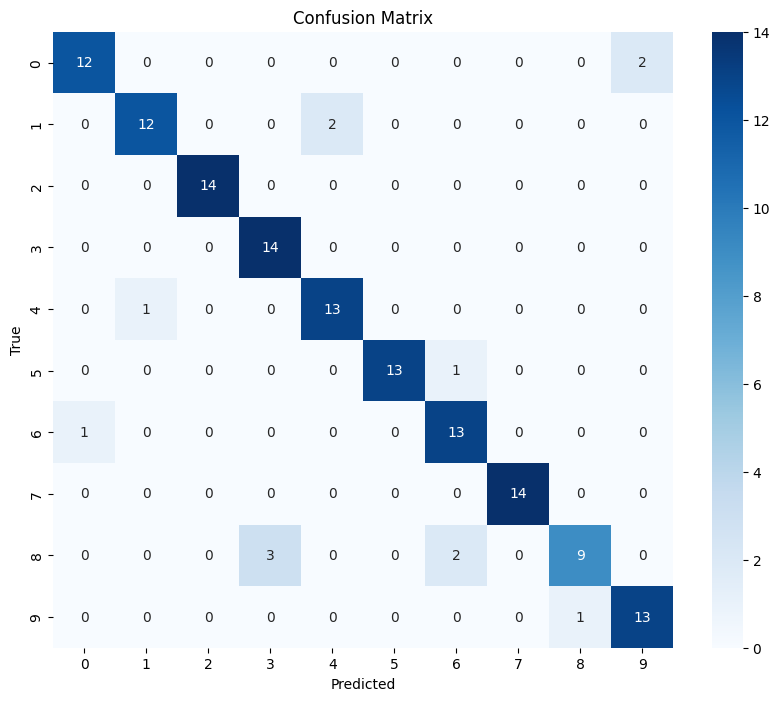

Overall Accuracy: 90.71%


In [12]:
accuracy_overall = evaluate(ensemble, test_loader, device=device)
print(f"Overall Accuracy: {accuracy_overall:.2f}%")